#  Introduction


Each blockchain works in a peer-to-peer environment. P2P environment is a network where peers are connected to each other and exchange information and run applications on top of it.

The goal of this notebook is to explain the building blocks for any blockchain system. 
- We will build a system block by block.
- Distributed systems are hard, there are many unpredictable errors: race conditions, nasty bugs, deadlocks.
- We will simplify the world to get to juiciest parts without leaving out the essentials.  


We will simulate the p2p enviorment locally to get the idea of how such system work and get the design decision that devloper make when designing such system.

To show different tradeoffs and why developers and researcher choose certain designs we need a way to simulate such environment. Here we will simulate network and message exchange with a [SimPy](simpy.readthedocs.io/en/latest/).

For the simplicity of use we implement a P2P network simulation: `p2psimpy`. 

# BaseSimulation

The simulation starts with a `BaseSimulation` class. This class represents the network of peers with their physical representations in the world, such as `location`, `bandwidth`. 

`BaseSimulation` requires 3 main parameters in the constructor: 
 - *Locations* - generator class for the locations. 
 - *Topology* - networkx graph with attribute `type`, or a dictionary `peer_id -> {'type': peer_type }` 
 - *Type map with services* - map `type -> PeerType object ` 

Let's go one by one. 

## Locations 

Simulator works in a space with different locations to simulate network latency. You have to define your own locations and latency between them. 

Locations are defined with as a `Config` class. 
This class can be used as generators of parameters, saved and loaded as yaml file. Parameters can be constant, or probabilistic(with a probability distribution).


Location configuration should contain at least two fields: `locations` and `latencies`. 
- `locations` is an array or a tuple with names of locations.
- `latencies` is a dictionary (matrix) with latencies of pairwise connections.

Depending on the experiments latencies can be constant, but a more realistic model is a probabilistic distribution.
Such distribution is represented with `Dist` class. 

`Dist` class is a wrap around [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm), which has rich collection of distributions.  

Finally,  `Config.get()` samples all the parameters from distributions and returns them as a dictionary.  

Let's try out:

In [1]:
from p2psimpy.config import *

class ConstLocations(Config):
    locations = ['LocA', 'LocB']
    latencies = {
        'LocA': {'LocB': 10, 'LocA': 2},
        'LocB': {'LocB': 1}
    }    

class DistLocations(Config):
    locations = ['LocA', 'LocB']
    latencies = {
        'LocB': {'LocB': Dist('gamma', (1, 1, 1))},
        'LocA': {'LocB': Dist('norm', (12, 2)), 'LocA': Dist('norm', (2, 0.5))},
    }    
    

In [2]:
ConstLocations.get()

{'latencies': {'LocA': {'LocB': 10, 'LocA': 2}, 'LocB': {'LocB': 1}},
 'locations': ['LocA', 'LocB']}

In [3]:
DistLocations.get()

{'latencies': {'LocB': {'LocB': 1.1425963618705468},
  'LocA': {'LocB': 13.093699068737694, 'LocA': 2.526922166807382}},
 'locations': ['LocA', 'LocB']}

Every time you call `Config.get()` it will return new sample

In [4]:
DistLocations.get()

{'latencies': {'LocB': {'LocB': 1.4160285927885958},
  'LocA': {'LocB': 14.491929939777217, 'LocA': 1.4787172980530185}},
 'locations': ['LocA', 'LocB']}

For the simplicity we can represent latencies sample as pandas dataframe. It provides readable table. 

In [5]:
import pandas as pd 

lat_sample = pd.DataFrame(DistLocations.get()['latencies'])
lat_sample

,LocB,LocA
LocB,3.118451,12.539468
LocA,NaN,1.799154


*Notice that table has **NaN** values. They will be automatically filled with symmetric value if not specified.*

We can transform the table to fill them up symmetrically. 

In [6]:
lat_sample[pd.isnull(lat_sample)] = lat_sample.T[pd.isnull(lat_sample)]
lat_sample

,LocB,LocA
LocB,3.118451,12.539468
LocA,12.539468,1.799154


---------------------
Let's visualize the data.

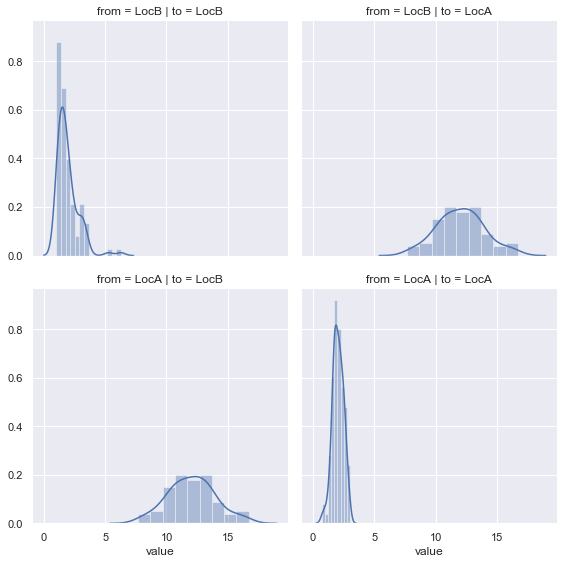

In [8]:
# -- Prepare data: 
#  - Trasfer to dataframe
#  - Fill null values with symmetic 
#  - Traform into list of tuples: 'from', 'to', 'value' 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

def prepare(x):
    x = pd.DataFrame(x)
    x[pd.isnull(x)] = x.T[pd.isnull(x)]
    return x.stack().reset_index()\
                    .rename(columns={'level_0':'from', 'level_1':'to', 0: 'value'})
                    
# 2. Get 100 samples from the configuration with latencies
df = pd.concat(prepare(DistLocations.get()['latencies']) for _ in range(100))

# Visualize in a grid of histograms
g = sns.FacetGrid(df, col='to', row='from', height=4, aspect=1)
g = g.map(sns.distplot, 'value')


## Peers and Topologies 

Simulation can work in two modes: 

1. **NetworkX**. When you pass a network topology: peers with all connections and peer types

2. **Emergent**. Peer communicate with each other through bootstrap peers and network topology emerges itself, as peers exchange data with each other. Usually peer-to-peer network follow into this category. You can read more [here](https://en.wikipedia.org/wiki/Bootstrapping_node), or  read how [Bitcoin network](https://en.bitcoin.it/wiki/Network) is formed.  




### Networkx topology

Let's first see how we can form a network topology.


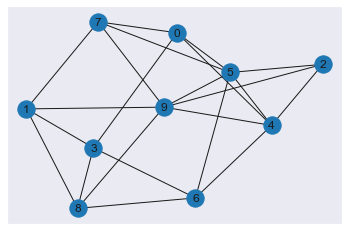

In [9]:
import networkx as nx

peer_num = 10
# Generate a network topology 
G = nx.erdos_renyi_graph(10, 0.5)

# Assign a peer type to the peers 
nx.set_node_attributes(G, {k: 'basic' for k in G.nodes()}, 'type')

sns.set(style='dark')
nx.draw_networkx(G)


NetworkX is a library that has rich semantics and collection of graph generators. You can read more [here](https://networkx.github.io/documentation/stable/reference/generators.html).  

You can choose any graph, generate them and put `type` as node attributes. `type` is a name for the peer type. We explain later how it will be used in a simulation.  



### Emergent topology

What if topology is not known?

In this case we can model the peer discovery mechanism through *bootstrapping* peers. General bootstrap process is following: 
1. Bootstrap nodes are create in the system first. The goal of bootstrap nodes is to maintain list of peers and connect them with each other upon request.
2. New peer joins the network. Peer sends a `Hello` message to one of bootstrap nodes. Bootstrap nodes are usually known in advance. Bootstrap node responds to the peer with a random sample of known online peers. 
3. The peer connect with other peers. 


This is all abstracted in simulation, but you can specify your own bootstrap logic later. 


To run default bootstrap you should pass as a parameter `topology` a dictionary with type `peer_id` -> {`type`: type_name}


## Peer types and services

Simulation also requires `peer_types` that is a map that describes peers in the system and the running scenario. 

Below we give an example of a simple map with one type: `basic`. Peer is described with a `PeerType(PeerConfig, services)`. `PeerConfig` describes with a configuration physical representation of a peer in the system. 
Each peer at minimum must have bandwidth and a location.  

Finally, peers must have services to run in the system. They work as a running scenario. 
There some implemented standard services that you can user in your simulation. But you will also implement your own later!

Each peer should have at least a connection service to build a network of peers and react on introduction messages. 
By default there two connection services: `BaseConnectionManager` and `P2PConnectionManager`. Both support basic connection primitives: connect, disconnect unresponsive peers. The difference is that later one will actively pull new peers to connect at least to `min_peers`, but when the number of connections is higher than `max_peers` it will start to refuse new connections and disconnect slowest peers. 

Let's see how it looks in code:


In [10]:
from p2psimpy.config import *
from p2psimpy.consts import *
    
class PeerConfig(Config):
    location = Dist('sample', DistLocations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Let's add ConnectionManager - that will periodically ping neighbours and check if they are online 
from p2psimpy.services.connection_manager import BaseConnectionManager
# For each service you can define own configuration, or use default values.   
# Lets use base connection manager - that will periodically ping peer and disconnect unresponsive peers.

services = (BaseConnectionManager,)
peer_types = {'basic': PeerType(PeerConfig, services)}

How to use these configuration. Configs are used to get value. 
They work as a generator and attribute descriptors.  

# Putting all together


Let's combine all you learned so far and run a simple simulation. 

1. Define locations and simulation world parameters.
2. Define topology and number of peers with their types.  
3. Define what each peer type is with a `PeerConfig` and what it does with services. 


After we defined all this we can create a simulation object and run it with `.run(time)`.

Simulation has it's internal clock and scheduler for all events. The parameter `time` is a time until which the simulation is run. 

***All the time is milliseconds**!





## Random given topology 

1. Given network with peer types and ids 
2. No network given - emergent P2P topology through bootstrap peers. 

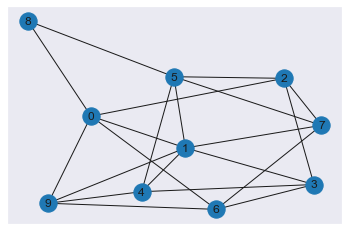

In [11]:
from p2psimpy.config import *
from p2psimpy.consts import *
import networkx as nx

class Locations(Config):
    locations = ['LocA', 'LocB']
    latencies = {
        'LocB': {'LocB': Dist('gamma', (1, 1, 1))},
        'LocA': {'LocB': Dist('norm', (12, 2)), 'LocA': Dist('norm', (2, 0.5))},
    } 

# Generate network topology 
G = nx.erdos_renyi_graph(10, 0.5)
# Assign a peer type to the peers 
nx.set_node_attributes(G, {k: 'basic' for k in G.nodes()}, 'type')

class PeerConfig(Config):
    location = Dist('sample', Locations.locations)
    bandwidth_ul = Dist( 'norm', (50*MBit, 10*MBit))
    bandwidth_dl = Dist( 'norm', (50*MBit, 10*MBit))

# Let's add ConnectionManager - that will periodically ping neighbours and check if they are online 
from p2psimpy.services.connection_manager import BaseConnectionManager
# For each service you can define own configuration, or use default values.   
# Lets use base connection manager - that will periodically ping peer and disconnect unresponsive peers.

services = (BaseConnectionManager,)
peer_types = {'basic': PeerType(PeerConfig, services)}

# Display the topology 
nx.draw_networkx(G)

In [12]:
from p2psimpy.simulation import BaseSimulation

sim = BaseSimulation(Locations, G, peer_types, enable_logger=True, logger_dir='logs')

# Let's run the simulation for 5 seconds
sim.run(5_000)

----------------------------

What's next? There is no output.

We run the simulator with logger enabled to see the all the messages exchanged in the network. 

The output by default is written to the logs in `\logs` directory. Let's see what is the output. 
Each peer writes own log with events happening like received message, connecting to a peer etc. 

For example:

In [13]:
with open('logs/Peer_1:basic.log') as s:
    print(s.read())

Peer_1:basic INFO 0.6489702246110659: Received message <Hello:> from Peer_4:basic
Peer_1:basic INFO 0.6489702246110659: Connecting to Peer_4:basic
Peer_1:basic INFO 0.6489702246110659: Sending message <Hello:> to Peer_4:basic
Peer_1:basic INFO 0.714713620497239: Received message <Hello:> from Peer_7:basic
Peer_1:basic INFO 0.714713620497239: Connecting to Peer_7:basic
Peer_1:basic INFO 0.714713620497239: Sending message <Hello:> to Peer_7:basic
Peer_1:basic INFO 0.811383749933676: Received message <Hello:> from Peer_9:basic
Peer_1:basic INFO 0.811383749933676: Connecting to Peer_9:basic
Peer_1:basic INFO 0.811383749933676: Sending message <Hello:> to Peer_9:basic
Peer_1:basic INFO 1.0476751104935136: Connecting to Peer_2:basic
Peer_1:basic INFO 1.1395662348270856: Received message <Hello:> from Peer_2:basic
Peer_1:basic INFO 2.3454898329830978: Received message <Hello:> from Peer_2:basic
Peer_1:basic INFO 5.972230080672046: Received message <Hello:> from Peer_3:basic
Peer_1:basic INFO 

## Emergent topology

Now let's try emergent topology, we will use the same configuration, but use bootstrap peer for discovery and building a network.  


In [14]:
from p2psimpy.services.connection_manager import P2PConnectionManager

num_peers = 10

topology_specs = {i:{'type': 'basic'} for i in range(1, num_peers+1)}

class ConnectionConfig(Config):
    min_peers = 4
    max_peers = 8

peer_types = {'basic': PeerType(PeerConfig, {P2PConnectionManager: ConnectionConfig})}


In [15]:
sim = BaseSimulation(Locations, topology_specs, peer_types, logger_dir='logs2')

# Let's run the simulation for 5 seconds
sim.run(5_000)

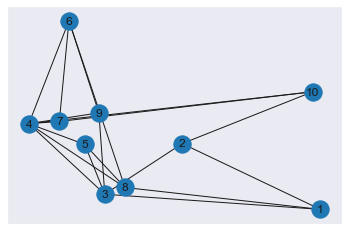

In [16]:
G1 = sim.get_graph()
nx.draw_networkx(G1)

In [17]:
with open('logs2/Peer_1:basic.log') as s:
    print(s.read())

Peer_1:basic WARNING 0: Not enough peers, fetching more (0, 4)
Peer_1:basic INFO 6.19163443321154: Connecting to Peer_11:bootstrap
Peer_1:basic INFO 11.297405337276157: Received message <Hello:> from Peer_11:bootstrap
Peer_1:basic INFO 11.679516200979812: Received message <RequestPeers:> from Peer_11:bootstrap
Peer_1:basic INFO 11.679516200979812: Sending message <PeerList> to Peer_11:bootstrap
Peer_1:basic WARNING 500: Not enough peers, fetching more (1, 4)
Peer_1:basic INFO 500: Sending message <RequestPeers:> to Peer_11:bootstrap
Peer_1:basic INFO 506.71690174144635: Received message <RequestPeers:> from Peer_11:bootstrap
Peer_1:basic INFO 506.71690174144635: Sending message <PeerList> to Peer_11:bootstrap
Peer_1:basic INFO 512.3032942909022: Received message <PeerList> from Peer_11:bootstrap
Peer_1:basic WARNING 1000: Not enough peers, fetching more (1, 4)
Peer_1:basic INFO 1000: Sending message <RequestPeers:> to Peer_11:bootstrap
Peer_1:basic INFO 1005.4248332104931: Connecting t

------------------

Now you get how to work a simulation, in the next notebook we will take a look into services and implement our own.  
